In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path
import sys
import os
os.chdir('../..')
sys.path.append('../..')

import menpo.io as mio
from menpo.landmark import labeller, left_ventricle_34,left_ventricle_34_trimesh,left_ventricle_34_trimesh1

from menpo.transform import ThinPlateSplines
from menpo.feature import *
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpofit.fitter import noisy_shape_from_bounding_box
from menpofit.visualize import plot_cumulative_error_distribution
from menpowidgets import *
from menpodetect import load_dlib_left_ventricle_detector
from menpo.io import export_pickle,import_pickle
from menpo.visualize import print_progress
import menpo.visualize

import project.utils.labeller_lv as labels
from project.utils import tfrecords
import predict_lv as predict
import project.utils.visualisation as visualisation

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io as io
from io import BytesIO
from IPython.display import Image
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist

import tensorflow as tf

# method to load a database
def load_database(path_to_images, crop_percentage,max_diagonal=400, max_images=None):
    images = []
    # load landmarked images
    for i in mio.import_images(path_to_images, max_images=max_images, verbose=True):
           
        # convert it to grayscale if needed
        if i.n_channels == 3:
            i = i.as_greyscale(mode='luminosity')
        # crop image
        i = i.crop_to_landmarks_proportion(crop_percentage)
        
        d = i.diagonal()
        if d > max_diagonal:
            i = i.rescale(float(max_diagonal) / d)
        # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
        
        labeller(i, 'PTS', left_ventricle_34)#lv_34_trimesh
        labeller(i, 'PTS', left_ventricle_34_trimesh1)
        labeller(i, 'PTS', left_ventricle_34_trimesh)
        #i= i.resize([256, 256])
        # append it to the list
        images.append(i)
    return images

In [3]:
# hg 特征
from project.hourglass import estimator
from tensorflow.contrib import learn
from tensorflow.core.protobuf import config_pb2
from menpo.feature import *
import project.hourglass.params as hgparams
from tensorflow.python.estimator.inputs import numpy_io 

from tensorflow.python.training import coordinator
from tensorflow.python.training import queue_runner_impl

from skimage import transform 
params = {
    hgparams.N_FEATURES: 128,
    hgparams.N_HOURGLASS: 1,
    hgparams.N_RESIDUALS: 3,
}
# Where is the model located?
model_dir = Path('models/lv/lv_1hg_lr1e-3_decay10/')
params[hgparams.N_LANDMARKS] = 34
# Instantiate Estimator
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
run_config = tf.contrib.learn.RunConfig(
    gpu_memory_fraction=1, session_config=config)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    with tf.device("/gpu:0"):
        nn = learn.Estimator(
        model_dir=str(model_dir),
        params=params,
        config=run_config,
        model_fn=estimator._model_fn)
        
        sess.run(tf.global_variables_initializer())
@ndfeature
def hg(image):
    _,h,w= image.shape
    image = image.reshape([w,h])
    image=transform.resize(image, (256, 256))
    image = image.reshape([1,256,256])
    data = np.zeros((1, 256, 256, 3), np.float32)  
    data[:,:, :, 0] = image
    data[:,:, :, 1] = image
    data[:,:, :, 2] = image
    data=data.astype(np.float32)
    #image=image/255.0
    with tf.device("/gpu:0"):
        input_fn = tf.estimator.inputs.numpy_input_fn(
          x={"image": data},
          num_epochs=1,
          shuffle=False)
        predictions = nn.predict(input_fn=input_fn)
        images_generator = visualisation.lv_predictions(predictions,
                                                    show_input_images=False,
                                                    show_combined_heatmap=True,
                                                    show_individual_heatmaps=False)

    images = menpo.base.LazyList.init_from_iterable(images_generator)

    def flatten(list_of_lists): return [
        item for sublist in list_of_lists for item in sublist]
    images = flatten(images)
    images[0] =images[0].resize([w, h]).rescale_pixels(0, 255.0)

    tf.reset_default_graph()
    return images[0].pixels
def hog_closure(image):
    return hog(image,cell_size=4, window_step_horizontal=1, window_step_vertical=1)

#hg(train_images[1])
#type(train_images[1])
#hg(train_images[4])
#visualize_images(hg(train_images[7]))

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_session_config': gpu_options {
  allow_growth: true
}
, '_model_dir': 'models\\lv\\lv_1hg_lr1e-3_decay10', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000016E353C7400>, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_environment': 'local', '_keep_checkpoint_max': 5, '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_task_type': None, '_master': '', '_save_checkpoints_secs': 600, '_evaluation_master': ''}


## Fit the AAM on test images

In [4]:
max_images = 167
test_images =load_database('data/images',crop_percentage=0.5,max_images=max_images)
#test_images = test_images[-70:]

#visualize_images(test_images)

Found 167 assets, index the returned LazyList to import.


In [5]:
sys.path.insert(0,'I:/menpo/project_lv' ) 

unified_path = Path('I:/menpo/project_lv/data/deformable/unified/no-op-unified.pkl')

if unified_path.exists():
    unified = mio.import_pickle(unified_path)
    print('load done')

from alabortcvpr2015.unified import GlobalUnifiedFitter, AICRLMS

fitter = GlobalUnifiedFitter(unified, algorithm_cls=AICRLMS, n_shape=[3, 12],
                            n_appearance=[25, 50])

load done


i:\develop\menpo-py3\menpo\shape\pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


In [13]:
from menpofit.fitter import noisy_shape_from_shape

detector=load_dlib_left_ventricle_detector("detector.svm")
def test():        
    fitting_results = []
    
    for image in print_progress(test_images):
        
        gt_shape = image.landmarks['PTS']
        bboxes = detector(image)
        #print("{} detected .".format(len(bboxes)))
        initial_bbox = bboxes[0]
        #tf.reset_default_graph()
       # result = fitter.fit_from_bb(image,  initial_bbox, max_iters=25, gt_shape=gt_shape, return_costs=True )
        initial_shape = noisy_shape_from_shape(fitter.reference_shape, gt_shape,noise_percentage=0.05)

        result = fitter.fit(image, initial_shape, max_iters=40, gt_shape=gt_shape)#, return_costs=True
        fitting_results.append(result)
        
    return fitting_results

In [14]:
test_path = Path('data/deformable/unified/no-op-holistic-unified-testresults.pkl')

if test_path.exists():
    test_results = mio.import_pickle(test_path)
else:
    test_results = test()
    mio.export_pickle(test_results, test_path, overwrite=True, protocol=2)

[====================] 100% (167/167) - done.                                   


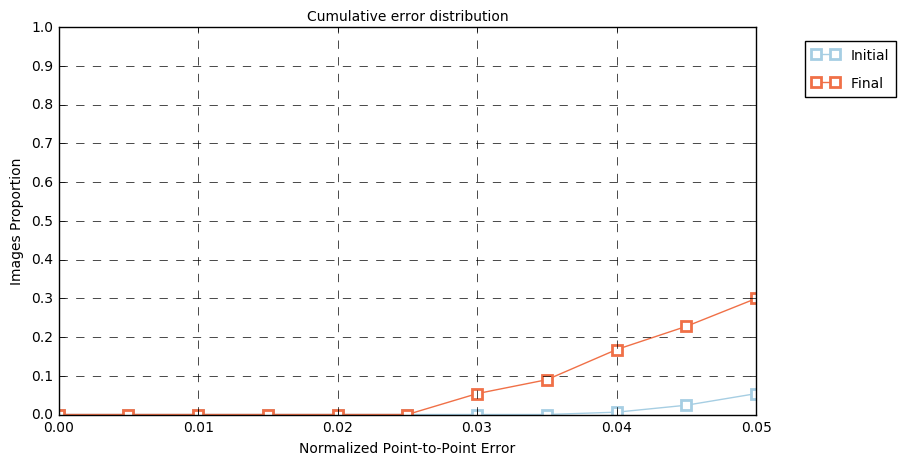

In [15]:
from menpowidgets import plot_ced

# Plot fitting error over test data (Cumulative Error Distribution)

initial_errors = [r.initial_error() for r in test_results]
final_errors = [r.final_error() for r in test_results]

plot_ced([initial_errors, final_errors], legend_entries=['Initial', 'Final'])

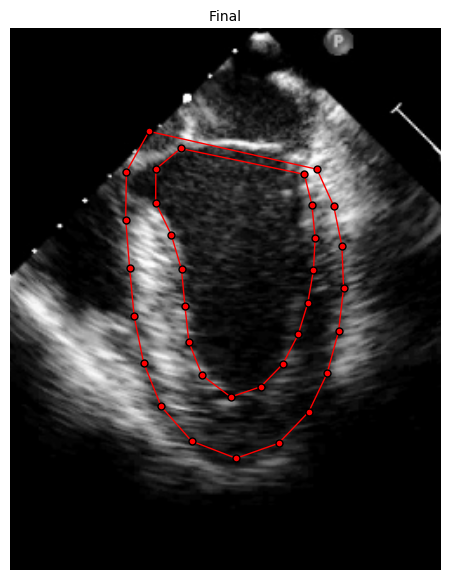

In [16]:
from menpowidgets import visualize_fitting_results 
visualize_fitting_results(test_results)

In [17]:
from menpo.image import Image
#Image(np.real(np.fft.fftshift(np.fft.ifft2(clm.classifiers[0][36].f)))).view()
#clm.view_expert_ensemble_widget()
#clm.view_shape_models_widget()
#clm.view_clm_widget()

In [18]:
unified_path = Path('I:/menpo/project_lv/data/deformable/unified/no-op-patch-unified.pkl')

if unified_path.exists():
    unified = mio.import_pickle(unified_path)
    print('load done')

from alabortcvpr2015.unified import PartsUnifiedFitter, AICRLMS, PICRLMS
sampling_mask = np.require(np.zeros(unified.parts_shape), dtype=np.bool)
sampling_mask[2::6, 2::6] = True
fitter = PartsUnifiedFitter(unified, algorithm_cls=AICRLMS, n_shape=[3, 12],
                            n_appearance=[25, 50],  sampling_mask=sampling_mask)

test_path = Path('data/deformable/unified/no-op-patch-unified-testresults.pkl')

if test_path.exists():
    test_results = mio.import_pickle(test_path)
else:
    test_results = test()
    mio.export_pickle(test_results, test_path, overwrite=True, protocol=2)

load done
[===============     ] 79% (133/167) - 00:00:11 remaining                       

i:\develop\menpo-py3\menpo\feature\features.py:833: UserWarning: One or more the scale factors are 0.0 and thus theseentries will be skipped during normalization.
  warnings.warn('One or more the scale factors are 0.0 and thus these'
I:/menpo/project_lv\alabortcvpr2015\clm\classifier.py:95: RuntimeWarning: invalid value encountered in true_divide
  axis=(-2, -1))[..., None, None]


[====================] 100% (167/167) - done.                                   


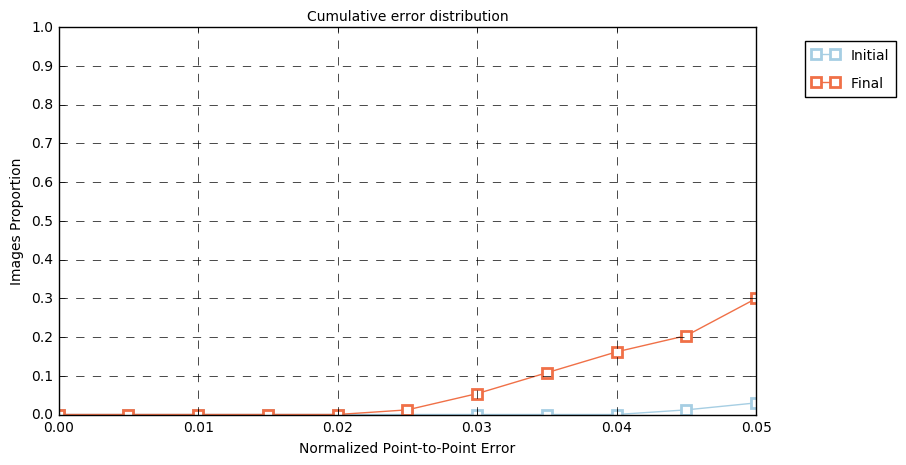

In [19]:
from menpowidgets import plot_ced

# Plot fitting error over test data (Cumulative Error Distribution)

initial_errors = [r.initial_error() for r in test_results]
final_errors = [r.final_error() for r in test_results]

plot_ced([initial_errors, final_errors], legend_entries=['Initial', 'Final'])